In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/MyDrive/clue"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/clue


In [157]:
# Imports
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np


In [158]:
# Other constants
DATASET_DIR = "./"
DATA_FILENAME = "dataset.csv"

In [159]:
dataframe = pd.read_csv(f"{DATASET_DIR}{DATA_FILENAME}")
dataframe.sample(5)

,GAME_ID,G_home,W_home,L_home,W_PCT_home,HOME_RECORD_home,ROAD_RECORD_home,G_prev_home,W_prev_home,L_prev_home,W_PCT_prev_home,HOME_RECORD_prev_home,ROAD_RECORD_prev_home,G_away,W_away,L_away,W_PCT_away,HOME_RECORD_away,ROAD_RECORD_away,G_prev_away,W_prev_away,L_prev_away,W_PCT_prev_away,HOME_RECORD_prev_away,ROAD_RECORD_prev_away,WIN_PRCT_home_3g,PTS_home_3g,FG_PCT_home_3g,FT_PCT_home_3g,FG3_PCT_home_3g,AST_home_3g,REB_home_3g,WIN_PRCT_away_3g,PTS_away_3g,FG_PCT_away_3g,FT_PCT_away_3g,FG3_PCT_away_3g,AST_away_3g,REB_away_3g,SEASON,HOME_TEAM_WINS
3907,20900960,61,36,25,0.590,0.687500,0.482759,82,54,28,0.659,0.682927,0.634146,63,22,41,0.349,0.400000,0.285714,82,32,50,0.390,0.487805,0.292683,0.666667,99.666667,0.480000,0.687667,0.458000,23.333333,38.666667,0.333333,96.000000,0.488333,0.785667,0.285000,19.666667,41.000000,2009,1
5141,21000741,50,26,24,0.520,0.681818,0.392857,82,40,42,0.488,0.560976,0.414634,49,8,41,0.163,0.238095,0.107143,82,61,21,0.744,0.853659,0.634146,1.000000,103.000000,0.507333,0.810333,0.382667,26.666667,41.000000,0.000000,96.333333,0.425667,0.779000,0.373667,18.666667,36.000000,2010,1
8872,21300645,43,26,17,0.605,0.666667,0.560000,82,47,35,0.573,0.682927,0.463415,41,20,21,0.488,0.600000,0.380952,82,31,51,0.378,0.487805,0.268293,0.333333,104.000000,0.457000,0.718000,0.399667,20.000000,40.333333,0.666667,99.666667,0.443000,0.735000,0.300333,24.000000,48.666667,2013,0
4016,11000019,2,2,0,1.000,1.000000,1.000000,82,12,70,0.146,0.195122,0.097561,1,1,0,1.000,1.000000,NaN,82,50,32,0.610,0.585366,0.634146,0.333333,94.666667,0.421000,0.738667,0.365667,18.000000,48.333333,0.333333,79.666667,0.394667,0.780667,0.271333,17.000000,42.333333,2010,0
15198,21701191,79,42,37,0.532,0.578947,0.487805,82,51,31,0.622,0.707317,0.536585,79,44,35,0.557,0.750000,0.358974,82,40,42,0.488,0.536585,0.439024,0.333333,104.000000,0.468667,0.787667,0.283000,21.000000,40.666667,1.000000,111.666667,0.432667,0.806000,0.308333,26.333333,51.000000,2017,0


In [160]:
# Remove rows with nan values
initial_len =  len(dataframe)
dataframe.dropna(inplace=True)
print(f"{len(dataframe)}/{initial_len}")

dataframe.info()

16735/17922
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16735 entries, 0 to 17921
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GAME_ID                16735 non-null  int64  
 1   G_home                 16735 non-null  int64  
 2   W_home                 16735 non-null  int64  
 3   L_home                 16735 non-null  int64  
 4   W_PCT_home             16735 non-null  float64
 5   HOME_RECORD_home       16735 non-null  float64
 6   ROAD_RECORD_home       16735 non-null  float64
 7   G_prev_home            16735 non-null  int64  
 8   W_prev_home            16735 non-null  int64  
 9   L_prev_home            16735 non-null  int64  
 10  W_PCT_prev_home        16735 non-null  float64
 11  HOME_RECORD_prev_home  16735 non-null  float64
 12  ROAD_RECORD_prev_home  16735 non-null  float64
 13  G_away                 16735 non-null  int64  
 14  W_away                 16735 non-null  int

40 2 ['NO', 'YES']


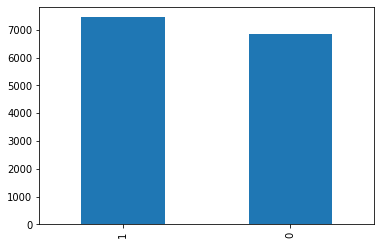

In [190]:
TARGET="HOME_TEAM_WINS"
input_size=len(dataframe.columns)-1
classes  = ["NO", "YES"]
output_size=len(classes)
print(input_size,  output_size,  classes)

target = dataframe[TARGET].value_counts()
target.plot(kind="bar")

14293/17922


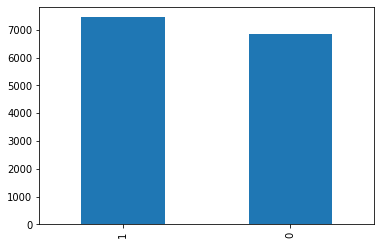

In [167]:
# Balance data

min_count = min(target.values)
max_count  = max(target.values)
remove_n = int((max_count -min_count) * 0.8)
temp = dataframe[dataframe[TARGET]==1]
drop_indices = np.random.choice(temp.index, remove_n, replace=False)

dataframe = dataframe.drop(drop_indices)

num_rows= len(dataframe)
print(f"{num_rows}/{initial_len}")

target = dataframe[TARGET].value_counts()
target.plot(kind="bar")

In [168]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop(TARGET, axis=1).values
targets = dataframe[[TARGET]].values
inputs.shape, targets.shape

((14293, 40), (14293, 1))

Classes: 2 - ['NO', 'YES'] 
Examples: 14293
Counts: {'NO': 6841, 'YES': 7452}


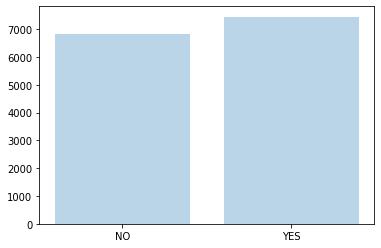

In [169]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.reshape(torch.tensor(targets,dtype=torch.int64), (-1,)))

def describe_dataset(data):
    classes_count = { c:0 for c in classes}
    for _,label in data:
        classes_count[classes[label]]+=1

    print(f'Classes: {len(classes)} - {classes} ')
    print(f'Examples: {len(data)}')
    print(f'Counts: {classes_count}')
    plt.bar(classes_count.keys(),classes_count.values(), alpha=0.3 )

    return classes_count

classes_count = describe_dataset(dataset)

In [170]:
# Split Dataset
val_percent = .15 
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

test_percent  = 0.5
test_size = int(val_size * test_percent)
val_size = val_size - test_size

val_ds, test_ds = random_split(val_ds, [val_size,  test_size])

# Hyperparameters
batch_size=128

# Create Dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

len(train_ds), len(val_ds) , len(test_ds)

(12150, 1072, 1071)

Classes: 2 - ['NO', 'YES'] 
Examples: 12150
Counts: {'NO': 5820, 'YES': 6330}


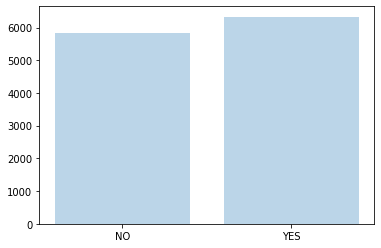

In [171]:
_ = describe_dataset(train_ds)

Classes: 2 - ['NO', 'YES'] 
Examples: 1072
Counts: {'NO': 514, 'YES': 558}


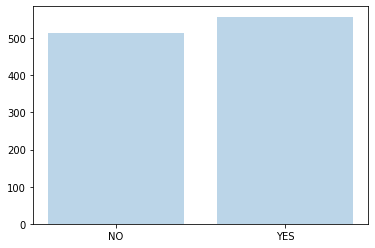

In [172]:
_ = describe_dataset(val_ds)

Classes: 2 - ['NO', 'YES'] 
Examples: 1071
Counts: {'NO': 507, 'YES': 564}


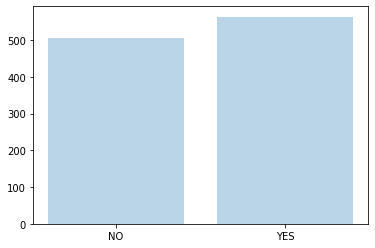

In [173]:
_ = describe_dataset(test_ds)

In [174]:
class BaseModel(nn.Module):
    def __init__(self, loss_fn=F.cross_entropy):
        super().__init__()
        self.loss_fn = loss_fn

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = self.loss_fn(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = self.loss_fn(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [227]:
class NBAModel(BaseModel):
  def __init__(self, input_size, output_size, loss_fn):
      super().__init__(loss_fn=loss_fn)
      self.network = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 24),
            nn.ReLU(),
            nn.Linear(24, output_size),
      )
    
  def forward(self, xb):
      return self.network(xb)

In [228]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

In [242]:
model = NBAModel(input_size, output_size, loss_fn=F.cross_entropy )

In [243]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.5375000238418579, 'val_loss': 38927.98046875}]

In [244]:
epochs = 20
max_lr = 0.00001
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [245]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                          grad_clip=grad_clip, 
                          weight_decay=weight_decay, 
                          opt_func=opt_func)

Epoch [0], last_lr: 0.00000, train_loss: 13837.6211, val_loss: 302.4692, val_acc: 0.5375
Epoch [1], last_lr: 0.00000, train_loss: 990.9446, val_loss: 1245.1924, val_acc: 0.4625
Epoch [2], last_lr: 0.00001, train_loss: 2496.8994, val_loss: 6142.5825, val_acc: 0.4625
Epoch [3], last_lr: 0.00001, train_loss: 2596.8103, val_loss: 2361.5518, val_acc: 0.4625
Epoch [4], last_lr: 0.00001, train_loss: 1872.9167, val_loss: 2440.7612, val_acc: 0.4625
Epoch [5], last_lr: 0.00001, train_loss: 2389.9758, val_loss: 1382.5496, val_acc: 0.5375
Epoch [6], last_lr: 0.00001, train_loss: 2490.9277, val_loss: 2920.2769, val_acc: 0.5375
Epoch [7], last_lr: 0.00001, train_loss: 2430.7134, val_loss: 1630.3561, val_acc: 0.5375
Epoch [8], last_lr: 0.00001, train_loss: 2207.6313, val_loss: 1839.3455, val_acc: 0.4625
Epoch [9], last_lr: 0.00001, train_loss: 1892.6591, val_loss: 2966.4897, val_acc: 0.4625
Epoch [10], last_lr: 0.00001, train_loss: 1584.8536, val_loss: 1854.6058, val_acc: 0.4625
Epoch [11], last_lr: 

In [246]:
test_result = evaluate(model, test_loader)
test_result

{'val_acc': 0.4747672975063324, 'val_loss': 4.047892093658447}

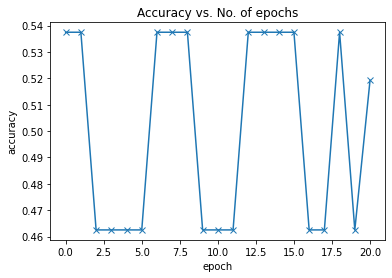

In [247]:
plot_accuracies(history)


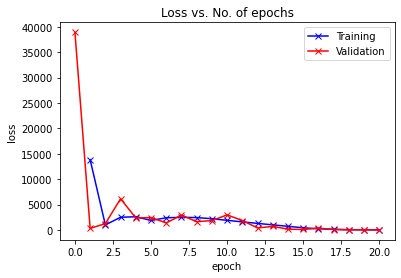

In [248]:
plot_losses(history)

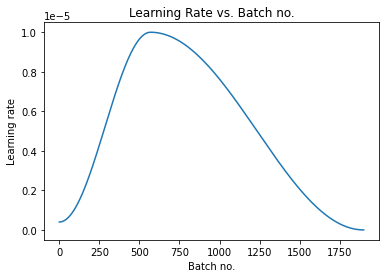

In [249]:
plot_lrs(history)

In [250]:
def predict_single(input, target, model):
    predictions = model(input) 
    _, preds = torch.max(predictions, dim=0)
    # print("Input:", input)
    print("Target:", classes[target.item()])
    print("Prediction:", classes[preds.item()])

In [251]:
input, target = test_ds[10]
predict_single(input, target, model)

Target: YES
Prediction: YES


In [252]:
input, target = test_ds[203]
predict_single(input, target, model)

Target: NO
Prediction: YES


In [253]:
input, target = test_ds[100]
predict_single(input, target, model)

Target: YES
Prediction: YES


In [254]:
for i,t in test_ds:
  predict_single(input, target, model)

Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Prediction: YES
Target: YES
Predicti

In [255]:
torch.save(model.state_dict(), 'nba_model.pth')